In [216]:
import os
import pickle
import numpy as np
import pandas as pd
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
from numpy import typing as npt

In [3]:
def unpickle(file:str)->dict:
    """
    Unpcikling the data files

    Args:
        file (str): filename

    Returns:
        dict
    """

    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [146]:

file_list=glob('../data/CIFAR10/cifar-10-batches-py/data_batch_*')
labels=[]
images=[]
for file in file_list:
    data = unpickle(file)
    labels.append(data[b'labels'])
    images.append(data[b'data'])
labels = np.concatenate(labels)
images = np.concatenate(images)
num_labels = np.unique(labels).shape[0]
num_images=images.shape[0]

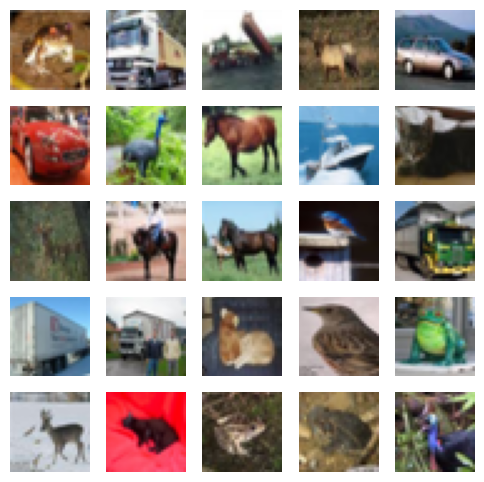

In [125]:
fig, axes = plt.subplots(5,5,figsize=(6,6))
count=0
for col in range(5):
    for row in range(5): 
        axes[col][row].imshow(np.transpose(np.reshape(images[count,:],(32,32,3),order='F'),(1,0,2)))
        axes[col][row].axis('off')
        count=count+1

In [161]:
def LossFunction(images:npt.NDArray, labels:npt.NDArray, weights:npt.NDArray, delta:float)->float:  
  
  num_images = len(labels)
  
  Scores = weights @ images.T
  margins = np.maximum(0,Scores-Scores[labels,np.arange(num_images)]+delta)
  margins[labels,np.arange(num_images)]=0
  loss = np.sum(margins)/num_images

  return loss

In [194]:
def LossFunctionAndGradient(images:npt.NDArray, labels:npt.NDArray, weights:npt.NDArray, delta:float, eps: float=1E-3)->tuple:  
  
  num_images = len(labels)
  
  Scores = weights @ images.T
  margins = np.maximum(0,Scores-Scores[labels,np.arange(num_images)]+delta)
  margins[labels,np.arange(num_images)]=0
  loss = np.sum(margins)/num_images

  num_pixels = weights.shape[1]  
  num_classes = weights.shape[0]
  
  gradient = np.zeros(weights.shape)
  for jind in range(num_pixels): 
    pert = eps*images.T[jind,:]
    for iind in range(num_classes):    
      newScores = Scores.copy()
      newScores[iind,:] = Scores[iind,:]+pert
      newmargins = np.maximum(0,newScores-newScores[labels,np.arange(num_images)]+delta)
      newmargins[labels,np.arange(num_images)]=0
      newloss = np.sum(newmargins)/num_images
      gradient[iind,jind]=(newloss - loss)/eps

  return (loss,gradient)

In [195]:

loss,gradient=LossFunctionAndGradient(images[selected_images,:],labels[selected_images],weights,1)

In [196]:
ComputedGradient=np.zeros(weights.shape)
for iind in range(weights.shape[0]):
    for jind in range(weights.shape[1]):
        newweights=weights.copy()
        newweights[iind,jind]=newweights[iind,jind]+1E-3
        newloss = LossFunction(images[selected_images,:],labels[selected_images],newweights,1)
        ComputedGradient[iind,jind]=(newloss-loss)/1E-3

print(np.max(np.abs(gradient-ComputedGradient)))

In [213]:
weights=np.random.random([num_labels,32*32*3])
num_steps=1000
learning_rate=0.1
records = []
for iind in range(num_steps):
    selected_images=np.random.randint(0,50000,100)
    loss,gradient=LossFunctionAndGradient(images[selected_images,:],labels[selected_images],weights,1)
    
    old_weights=weights.copy()
    
    grad_mag = np.linalg.norm(gradient)
    
    if(iind%100==0):
        learning_rate = 0.5*learning_rate

    weights = weights-learning_rate*gradient/grad_mag
    records.append([iind+1,loss,learning_rate,grad_mag])

    print(f'Step - {iind+1}, Loss - {loss}, Learning Rate - {learning_rate}, magnitude of gradient - {grad_mag}')
    
    if(grad_mag <1E-6):
        break;


Step - 1, Loss - 7681.560317912472, Learning Rate - 0.05, magnitude of gradient - 10526.273604680206
Step - 2, Loss - 7589.309958054311, Learning Rate - 0.05, magnitude of gradient - 8572.054721012244
Step - 3, Loss - 7383.350550469605, Learning Rate - 0.05, magnitude of gradient - 9538.33564266529
Step - 4, Loss - 7661.913237319083, Learning Rate - 0.05, magnitude of gradient - 8763.193490232423
Step - 5, Loss - 7615.346301347214, Learning Rate - 0.05, magnitude of gradient - 9196.837933233706
Step - 6, Loss - 6770.164662365839, Learning Rate - 0.05, magnitude of gradient - 9649.784989593258
Step - 7, Loss - 6729.392059493777, Learning Rate - 0.05, magnitude of gradient - 8433.579639795542
Step - 8, Loss - 5562.705409375743, Learning Rate - 0.05, magnitude of gradient - 7152.923492874307
Step - 9, Loss - 5256.796158189456, Learning Rate - 0.05, magnitude of gradient - 7325.548344733036
Step - 10, Loss - 4171.423257001007, Learning Rate - 0.05, magnitude of gradient - 5647.054654666386

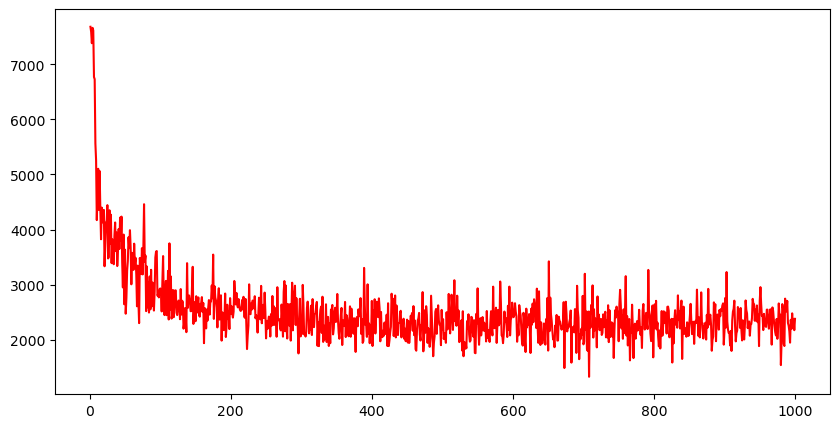

In [218]:
df=pd.DataFrame.from_records(records,columns=['Step','Loss','Gradient_Magnitude'])
plt.figure(figsize=[10,5])
plt.plot(df['Step'],df['Loss'],'-r')